<font size="9">Kernel Functions Profiling</font><br>
<hr>

In [1]:
import logging
reload(logging)
logging.basicConfig(
    format='%(asctime)-9s %(levelname)-8s: %(message)s',
    datefmt='%I:%M:%S')

# Enable logging at INFO level
logging.getLogger().setLevel(logging.INFO)
# Comment the follwing line to disable devlib debugging statements
logging.getLogger('ssh').setLevel(logging.DEBUG)

In [2]:
# Generate plots inline
%pylab inline

import json
import os

import re
import collections
import pandas

Populating the interactive namespace from numpy and matplotlib


## Define folder containgin profiling data

In [3]:
# Base folder where tests folder are located
res_dir = '../../results_latest/'
logging.info('Content of the output folder %s', res_dir)
#!tree {res_dir}

11:50:08  INFO    : Content of the output folder ../../results_latest/


## Load function profiling data

In [4]:
def autodict():
    return collections.defaultdict(autodict)

def parse_perf_stat(res_dir):
    TEST_DIR_RE = re.compile(r'.*/([^:]*):([^:]*):([^:]*)')
    profiling_data = autodict()

    for test_idx in sorted(os.listdir(res_dir)):
        test_dir = os.path.join(res_dir, test_idx)
        if not os.path.isdir(test_dir):
            continue
        match = TEST_DIR_RE.search(test_dir)
        if not match:
            continue
        wtype = match.group(1)
        tconf = match.group(2)
        wload = match.group(3)

        #logging.info('Processing %s:%s:%s', wtype, tconf, wload)
        trace_stat_file = os.path.join(test_dir, '1', 'trace_stat.json')
        if not os.path.isfile(trace_stat_file):
            continue
        with open(trace_stat_file, 'r') as fh:
            data = json.load(fh)
        for cpu_id, cpu_stats in sorted(data.items()):
            for fname in cpu_stats:
                profiling_data[cpu_id][tconf][fname] = cpu_stats[fname]

    return profiling_data
  
profiling_data = parse_perf_stat(res_dir)
#logging.info("Profiling data:\n%s", json.dumps(profiling_data, indent=4))
#profiling_data

## Build Pandas DataFrame from profiling data

In [5]:
def get_df(profiling_data):
    cpu_ids = []
    cpu_frames = []
    for cpu_id, cpu_data in sorted(profiling_data.items()):
        cpu_ids.append(cpu_id)
        conf_ids = []
        conf_frames = []
        for conf_id, conf_data in cpu_data.iteritems():
            conf_ids.append(conf_id)
            function_data = pandas.DataFrame.from_dict(conf_data, orient='index')
            conf_frames.append(function_data)
        df = pandas.concat(conf_frames, keys=conf_ids)
        cpu_frames.append(df)
    df = pandas.concat(cpu_frames, keys=cpu_ids)
    #df.head()
    return df

stats_df = get_df(profiling_data)
#stats_df

## Plot profiling data per function and CPU

In [6]:
def plot_stats(df, fname, axes=None):
    func_data = df.xs(fname, level=2)
    func_stats = func_data.xs(['avg', 's_2'], axis=1)
    #func_stats
    func_avg = func_stats.unstack(level=1)['avg']
    func_std = func_stats.unstack(level=1)['s_2'].apply(numpy.sqrt)
    func_avg.plot(kind='bar', title=fname, yerr=func_std, ax=axes);

#plot_stats(stats_df, 'sched_group_energy')

11:50:21  INFO    : Plotting stats for [sched_group_energy] function
11:50:21  INFO    : Plotting stats for [select_task_rq_fair] function
11:50:21  INFO    : Plotting stats for [energy_diff] function
11:50:21  INFO    : Plotting stats for [schedtune_dequeue_task] function
11:50:21  INFO    : Plotting stats for [schedtune_enqueue_task] function
11:50:21  INFO    : Plotting stats for [schedtune_task_boost] function


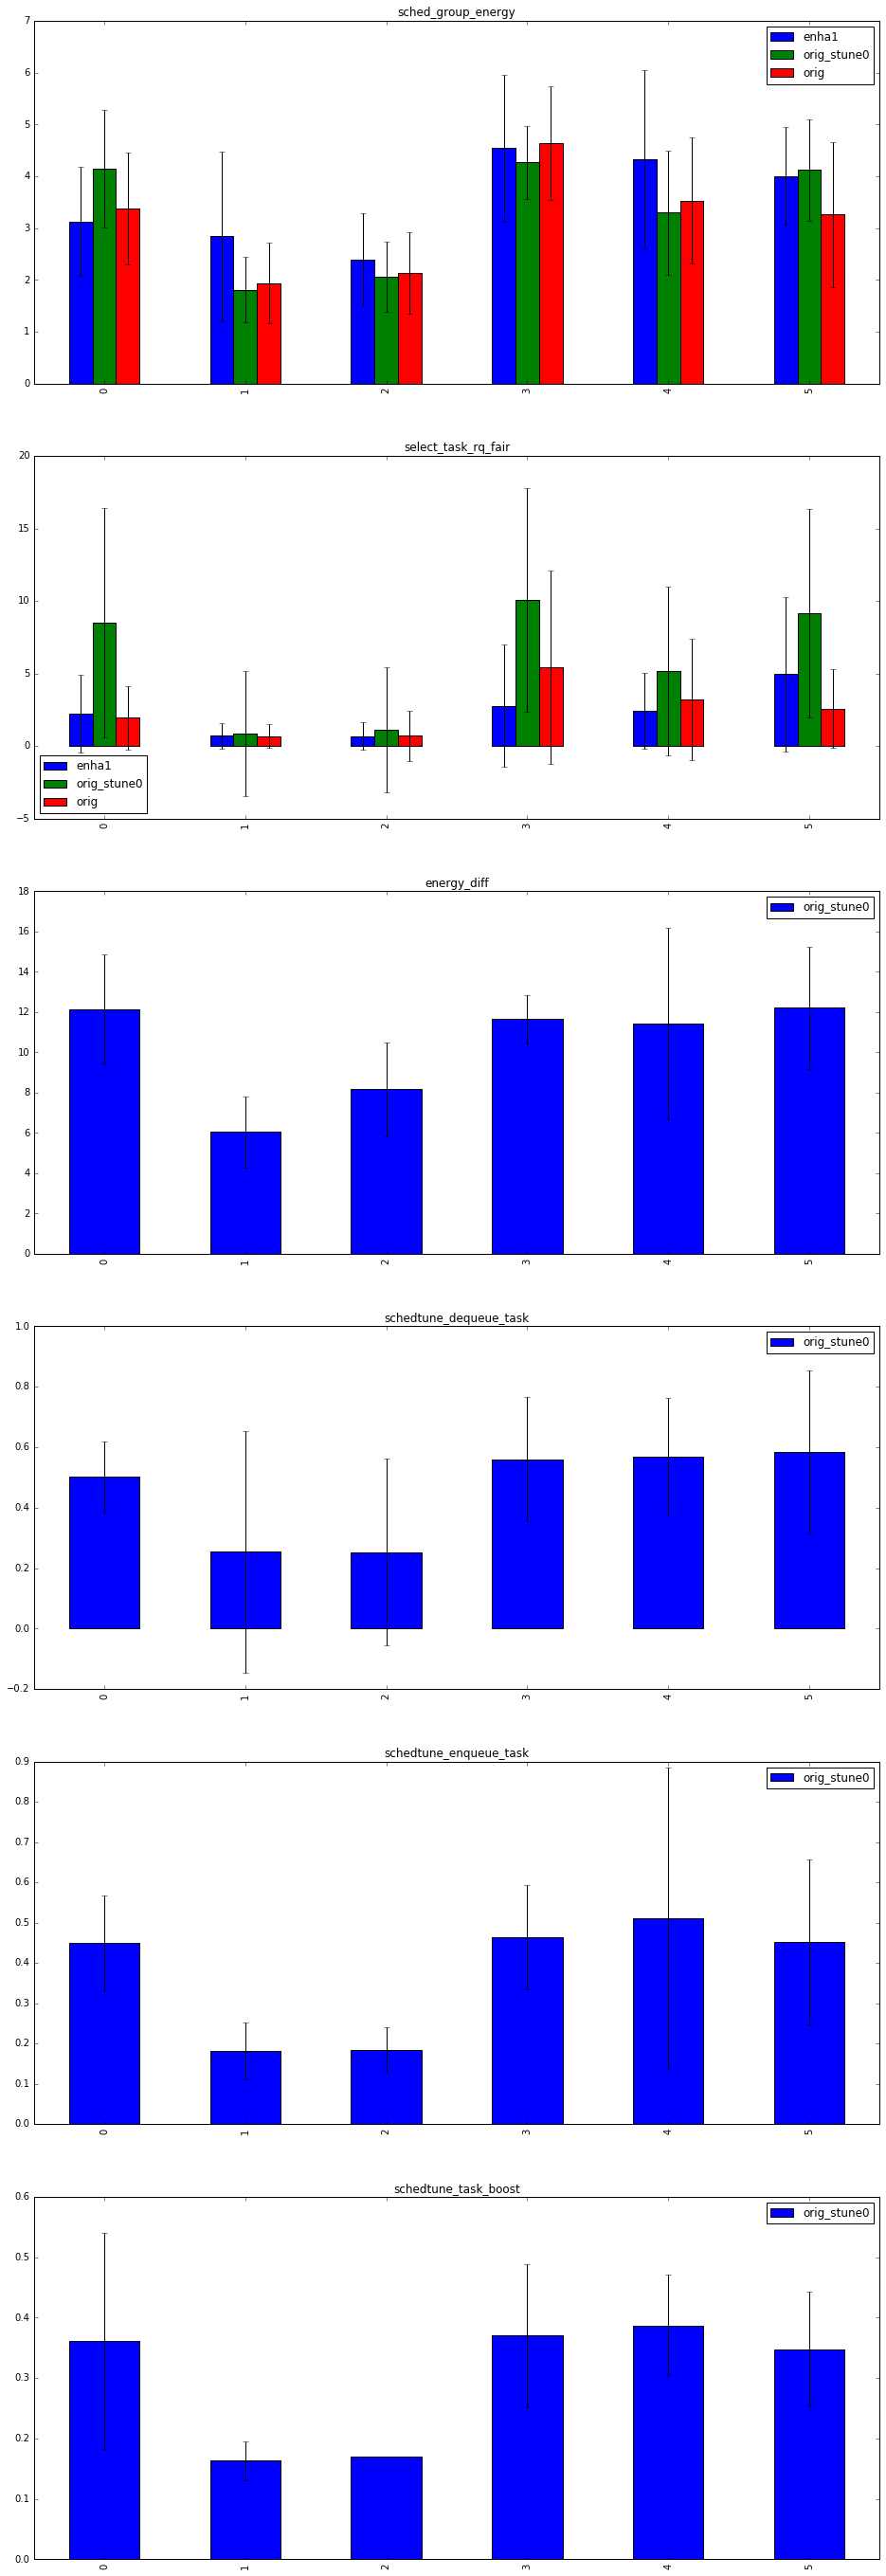

In [7]:
def plot_all_functions(df):
    functions = df.index.get_level_values(2).unique()
    fcount = len(functions)

    fig, pltaxes = plt.subplots(fcount, 1, figsize=(16, 8*fcount))

    fig_id = 0
    for fname in functions:
        logging.info("Plotting stats for [%s] function", fname)
        axes = pltaxes[fig_id]
        plot_stats(df, fname, axes)
        fig_id = fig_id + 1
        
plot_all_functions(stats_df)